# TP4. Réseaux de neurones convolutionnels.
## UE apprentissage statistique et réseaux de neurones.
## Master mathématiques appliquées, statistique -  parcours data science.
## Frédéric Richard, AMU, 2025.

L'objectif de ce TP est d'apprendre à mettre en oeuvre des réseaux de neurones convolutionnels pour effectuer des taches de classifi cation. Dans un premier temps, on s'intéresse à la classification des chiffres manuscrits de la base de données MNIST. Puis, on travaille sur un problème de détection de fissures sur des images de matériaux.

**Déclaration des librairies et méthodes utiles au TP:**

In [5]:
# Méthodes de pytorch.
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from torch.nn import Module, Linear, CrossEntropyLoss, BCEWithLogitsLoss
from torch.optim import SGD, Adam
from torch import Tensor, no_grad
from torch import flatten, max
from torch import manual_seed 
from torch import device as torch_device
from torch.backends.cudnn import deterministic
from torch.cuda import is_available as cuda_is_available
import torch
import torch.nn as nn
import torch.nn.functional as F

# Méthodes de torchvision.
from torchvision import transforms

# Méthodes système.
import glob

# Méthodes numpy.
from numpy import array

# Méthodes de scikit-learn.
from sklearn.model_selection import train_test_split

# Méthodes de matplotlib
from matplotlib import pyplot as plt

# Méthodes I/O images
from imageio.v3 import imread

RuntimeError: Only a single TORCH_LIBRARY can be used to register the namespace triton; please put all of your definitions in a single TORCH_LIBRARY block.  If you were trying to specify implementations, consider using TORCH_LIBRARY_IMPL (which can be duplicated).  If you really intended to define operators for a single namespace in a distributed way, you can use TORCH_LIBRARY_FRAGMENT to explicitly indicate this.  Previous registration of TORCH_LIBRARY was registered at /dev/null:2504; latest registration was registered at /dev/null:2504

## 1. Classification des chiffres manuscrits.

### 1.1. Préparation des données.


On commence par charger la base de données MNIST et à la préparer pour le traitement. Les images de la base sont normalisées. On définit une générateur de batchs (mini-lots) pour l'apprentissage et le test, qui intégre des transformations sur les images. 

In [ ]:
def load_mnist(batch_size=64):
    # Définition des transformations : conversion en tenseur et normalisation
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)) # Normalisation pour MNIST
    ])

    # Chargement des ensembles d'entraînement et de test
    train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
    
    # Création des DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, test_loader


train_loader, test_loader = load_mnist()

# Affichage d'un batch pour vérification
images, labels = next(iter(train_loader))
print(f"Taille du batch : {images.shape}")  # Devrait afficher (batch_size, 1, 28, 28)
print(f"Labels : {labels[:10]}")

NameError: name 'transforms' is not defined

### 1.2. Régression multinomiale.

Tout d'abord, on effectue la classification des images mnist à partir d'une régression multinomiale.

**Définition du réseau :** On définit le réseau de neurones qui permet de faire de la régression multinomiale sur la base MNIST.

In [ ]:
class MultinomialRegression(Module):
    def __init__(self):
        super(MultinomialRegression, self).__init__()
        self.linear = Linear(28 * 28, 10)
    
    def forward(self, x):
        x = flatten(x, 1)  # Vectorisation des images
        return self.linear(x)

**Apprentissage du réseau :** On minimise un critère d'entropie croisée avec un algorithme de gradient stochastique par mini-lots.

On prépare l'apprentissage.

In [ ]:
# Définition d'une valeur de départ aléatoire (seed).
random_seed = 12
# Initialisation du seed pour le générateur de nombres aléatoires de PyTorch.
manual_seed(random_seed)
# Définition du drapeau "deterministic" pour le backend CUDA de PyTorch à True.
deterministic = True
# Détermine le périphérique à utiliser pour les calculs (GPU ou CPU).
device = torch_device("cuda" if cuda_is_available() else "cpu")
# Affiche le périphérique sélectionné (soit "cuda" ou "cpu").
device

device(type='cpu')

On définit le modèle, la fonction de perte et l'optimiseur.

In [ ]:
# Instanciation du modèle.
model = MultinomialRegression().to(device)
# fonction de perte: entropie croisée.
criterion = CrossEntropyLoss()
# optimiseur: algorithme de gradient stochastique par mini-lots.
optimizer = SGD(model.parameters(), lr=0.01)
nb_epoques = 3  # Nombre d'éqoques.

for epoch in range(nb_epoques):
    running_loss = 0.0
    for i, (X, Y) in enumerate(train_loader):
        # Réinitialisation des gradients
        optimizer.zero_grad()
        # Passage avant
        outputs = model(X)
        loss = criterion(outputs, Y)
        # Rétropropagation et optimisation
        loss.backward()
        optimizer.step()
        # Calcul de la perte moyenne.
        running_loss += loss.item()
    # Affichage des statistiques de perte
    print(f"[{epoch + 1}] loss = {running_loss / len(train_loader):.3f}")

[1] loss = 0.468
[2] loss = 0.333
[3] loss = 0.312


**Evaluation.** On évalue le modèle sur la base de test en calculant la précision du modèle (pourcentage d'images correctement classées).

On définit une fonction pour calculer une erreur de classification (*accuracy*).

In [ ]:
def evaluate(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total * 100 

In [ ]:
print(f"Précision (apprentissage) : {evaluate(model, train_loader):.1f} %")
print(f"Précision (test) : {evaluate(model, test_loader):.1f} %")

Précision (apprentissage) : 91.5 %
Précision (test) : 91.7 %


In [ ]:
from torchsummary import summary

# Affichage de la complexité du modèle (paramètres entraînables)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
summary(model, (1, 28, 28))  # Exemple pour des images de 28x28 pixels

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]           7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


### 1.3. Réseaux de neurones convolutionnels.

1. En vous inspirant du modèle de régression logistique, créer le réseau de neurones convolutionnel (CNN 1) suivant:

| **Couche** |  **Spécifications** | **Dimension de la sortie** | **Nombre de paramètres** |
| --- | --- | --- | --- | 
| Input | - | (28, 28) | - |
| Convolution 2D  | 32 filtres de taille 3 x 3, activation ReLU  |  ..... | ..... |
| Max Pooling     | Taille de fenêtre 2 x 2 et sous-échantillonage de pas 2  | ......  | ..... |
| Vectorisation   | -   | ..... | ..... |
| Dense | 10 cellules  | ..... | ..... |

2. Faire l'apprentissage du CNN 1.
3. Comparer le CNN 1 au modèle de régression logistique en termes de complexité (nombre de paramètres) et de précision.
4. Mêmes questions avec le réseau de neurones convolutionel (CNN 2):

| **Couche** |  **Spécifications** | **Dimension de la sortie** | **Nombre de paramètres** |
| --- | --- | --- | --- | 
| Input | - | (28, 28) | - |
| Convolution 2D n°1 | 32 filtres de taille 3 x 3, activation ReLU  |  ..... | ..... |
| Max Pooling     | Taille de fenêtre 2 x 2 et sous-échantillonage de pas 2  | ......  | ..... |
| Convolution 2D n°2 | 64 filtres de taille 3 x 3, activation ReLU  |  ..... | ..... |
| Max Pooling     | Taille de fenêtre 2 x 2 et sous-échantillonage de pas 2  | ......  | ..... |
| Vectorisation   | -   | ..... | ..... |
| Dense n°1 | 128 cellules  | ..... | ..... |
| Dense n°2 | 10 cellules  | ..... | ..... |

In [ ]:
class CNN1(nn.Module):
    def __init__(self):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 14 * 14, 10)  

    def forward(self, x):
        x = F.relu(self.conv1(x))  
        x = self.pool(x)  
        x = torch.flatten(x, 1)  
        x = self.fc1(x)  
        return x

In [ ]:
# Instanciation du modèle.
model = CNN1().to(device)
# fonction de perte: entropie croisée.
criterion = CrossEntropyLoss()
# optimiseur: algorithme de gradient stochastique par mini-lots.
optimizer = SGD(model.parameters(), lr=0.01)
nb_epoques = 3  # Nombre d'éqoques.

for epoch in range(nb_epoques):
    running_loss = 0.0
    for i, (X, Y) in enumerate(train_loader):
        # Réinitialisation des gradients
        optimizer.zero_grad()
        # Passage avant
        outputs = model(X)
        loss = criterion(outputs, Y)
        # Rétropropagation et optimisation
        loss.backward()
        optimizer.step()
        # Calcul de la perte moyenne.
        running_loss += loss.item()
    # Affichage des statistiques de perte
    print(f"[{epoch + 1}] loss = {running_loss / len(train_loader):.3f}")

[1] loss = 0.328
[2] loss = 0.173
[3] loss = 0.130


In [ ]:
# Calcul de la précision
train_acc = evaluate(model, train_loader)
test_acc = evaluate(model, test_loader)

print(f"Précision (train) : {train_acc:.2f} %")
print(f"Précision (test) : {test_acc:.2f} %")

Précision (train) : 96.95 %
Précision (test) : 96.97 %


In [ ]:
# Affichage de la complexité du modèle (paramètres entraînables)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
summary(model, (1, 28, 28))  # Exemple pour des images de 28x28 pixels

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
            Linear-3                   [-1, 10]          62,730
Total params: 63,050
Trainable params: 63,050
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.24
Params size (MB): 0.24
Estimated Total Size (MB): 0.48
----------------------------------------------------------------


Modèle de régression logistique :
- Entrée : $ 28 \times 28 = 784 $ pixels  
- Nombre total de paramètres : $ 784 \times 10 + 10 = 7850 $ (car 10 classes de sortie)

Modèle CNN 1 :
- Entrée : $ 28 \times 28 = 784 $ pixels
- Couche convolutionnelle : $ 1 \times 32 \times 3 \times 3 + 32 = 320 $ (1 canal d'entrée et 32 filtres de sortie de taille $ 3 \times 3 $)
- Couche fully connected : $ 32 \times 14 \times 14 \times 10 + 10 = 62 730 $ (32 canaux d'entrée d'une image réduite à $ 14 \times 14 $ pixels et 10 classes de sortie)
- Nombre total de paramètres : $ 62 730 + 320 = 63 050 $

CNN 1 est donc beaucoup plus complexe, il a plus de 8 fois plus de paramètres que la régression logistique mais il est plus performant, $ 96,7 \% $ de précison contre $ 91,7 \% $ pour le modèle de régression logistique.

In [ ]:
# Définition du CNN 2
class CNN2(nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(7 * 7 * 64, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))  # Convolution 1 + ReLU
        x = self.pool(x)  # Max-Pooling 1
        x = self.relu(self.conv2(x))  # Convolution 2 + ReLU
        x = self.pool(x)  # Max-Pooling 2
        x = torch.flatten(x, 1)  # Vectorisation
        x = self.relu(self.fc1(x))  # Dense 1 + ReLU
        x = self.fc2(x)  # Dense 2 (Sortie)
        return x

In [ ]:
# Instanciation du modèle.
model = CNN2().to(device)
# fonction de perte: entropie croisée.
criterion = CrossEntropyLoss()
# optimiseur: algorithme de gradient stochastique par mini-lots.
optimizer = SGD(model.parameters(), lr=0.01)
nb_epoques = 3  # Nombre d'éqoques.

for epoch in range(nb_epoques):
    running_loss = 0.0
    for i, (X, Y) in enumerate(train_loader):
        # Réinitialisation des gradients
        optimizer.zero_grad()
        # Passage avant
        outputs = model(X)
        loss = criterion(outputs, Y)
        # Rétropropagation et optimisation
        loss.backward()
        optimizer.step()
        # Calcul de la perte moyenne.
        running_loss += loss.item()
    # Affichage des statistiques de perte
    print(f"[{epoch + 1}] loss = {running_loss / len(train_loader):.3f}")

[1] loss = 0.505
[2] loss = 0.155
[3] loss = 0.101


In [ ]:
# Calcul de la précision
train_acc = evaluate(model, train_loader)
test_acc = evaluate(model, test_loader)

print(f"Précision (train) : {train_acc:.2f} %")
print(f"Précision (test) : {test_acc:.2f} %")

Précision (train) : 97.36 %
Précision (test) : 97.48 %


In [ ]:
# Affichage de la complexité du modèle (paramètres entraînables)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
summary(model, (1, 28, 28))  # Exemple pour des images de 28x28 pixels

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,496
              ReLU-5           [-1, 64, 14, 14]               0
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Linear-7                  [-1, 128]         401,536
              ReLU-8                  [-1, 128]               0
            Linear-9                   [-1, 10]           1,290
Total params: 421,642
Trainable params: 421,642
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.65
Params size (MB): 1.61
Estimated Total Size (MB): 2.26
-------------------------------------------

Modèle CNN 2 :
- Entrée : $ 28 \times 28 = 784 $ pixels
- Couche convolutionnelle 1 : $ 1\times 32 \times 3 \times 3 + 32 = 320 $ (1 canal d'entrée et 32 filtres de sortie de taille $ 3 \times 3 $)
- Couche convolutionnelle 2 : $ 32 \times 64 \times 3 \times 3 + 64 = 18 496 $ (32 canaux d'entrée et 64 filtres de sortie de taille $ 3 \times 3 $)
- Couche fully connected 1 : $ 64 \times 7 \times 7 \times 128 + 128 = 401 536 $ (64 canaux d'entrée d'une image réduite à $ 7 \times 7 $ pixels et 128 neurones de sortie)
- Couche fully connected 2 : $ 128 \times 10 + 10 = 1290 $ (128 neurones d'entrée et 10 classes de sortie)
- Nombre total de paramètres : $ 320 + 18 496 + 401 536 + 1290 = 421 642 $

Le modèle CNN 2 est donc environ 7 fois plus complexe que le modèle CNN 1 et environ 54 fois plus complexe que le modèle de régression logistique. En revanche, il est plus précis que ces deux modèles : $ 97,5 \% $ de précison contre $ 96,7 \% $ pour le modèle CNN 1 et $ 91,7 \% $ pour le modèle de régression logistique. 

## 1. Détection des fissures sur des images de matériaux.

### 1.1. Présentation des données.

Les données se trouvent sur le site [surface crack detection](https://www.kaggle.com/datasets/arunrk7/surface-crack-detection) de Kaggle. Elles sont constituées d'images de matériaux dont certains comportent des fissures et d'autres non. L'objectif est de construire un réseau de neurones qui permet de détecter ces fissures.

### 1.2. Préparation des données.

On commence par mettre à disposition les données. Plusieurs solutions sont possibles. Lorsqu'on travaille sur Kaggle, on peut mettre à disposition les données dans le répertoire de travail */kaggle/working/* en utilisant les outils dédiés de kaggle.

In [ ]:
import zipfile
import os

zip_path = "archive.zip"  
image_dir = "archive"

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(image_dir)

On fait ensuite la liste des accès physiques vers les images en distiguant celles qui ont des fissures (dans le répertoire Positive) de celles qui n'en ont pas (dans le répertoire Negative). On crée également un vecteur d'étiquettes pour associer la classe à chaque image.

In [ ]:
pos_images = glob.glob(os.path.join(image_dir, 'Positive', '*.jpg'))
neg_images = glob.glob(os.path.join(image_dir, 'Negative', '*.jpg'))
images = pos_images + neg_images
labels = array([1] * len(pos_images) + [0] * len(neg_images))

On peut visualiser quelques images pour se rendre compte des données.

archive/Positive/10377_1.jpg


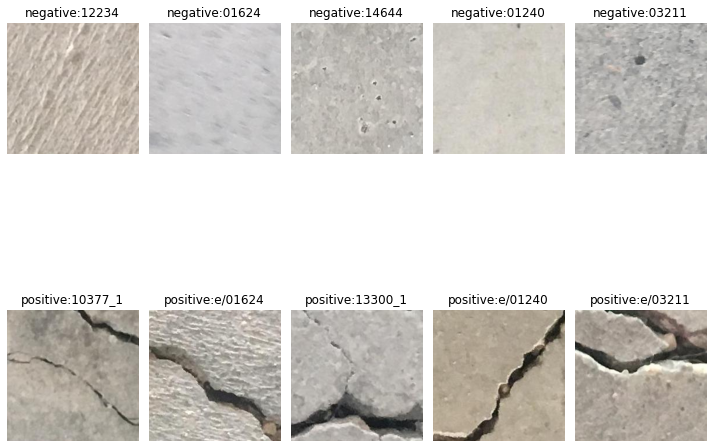

In [ ]:
def Affiche_Image(path, cnt, titre):
    img = imread(path)
    plt.subplot(2, 5, cnt)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(titre)

# Afficher les images
plt.figure(figsize=(10, 10))
cnt = 1
for i  in range(5):
    path = neg_images[i]
    titre = "negative:" + path[-9:-4]
    Affiche_Image(path, cnt, titre)
    cnt += 1
for i  in range(5):
    path = pos_images[i]
    titre = "positive:" + path[-11:-4]
    Affiche_Image(path, cnt, titre)
    cnt += 1

plt.tight_layout()
plt.show
print(pos_images[0])

Ensuite, on répartie les images en trois sous-ensembles des sous-ensembles qui seront utilisé pour l'entraînement, la validation et le test. Pour cela, on peut utiliser une méthode de scikit-learn qui permet de constituer des sous-ensembles équilibrés entre les deux classes (positif et négatif).

In [ ]:
# On sépare les données de test du reste des données en retenant au hasard 20% des données.
images_reste, images_test, y_reste, labels_test = train_test_split(images, labels,
                                                        test_size=0.2, random_state=12, shuffle=True)

images_train, images_val, labels_train, labels_val = train_test_split(images_reste, y_reste,
                                                            test_size=0.25, random_state=12, shuffle=True)

print(f"Taille de la base d'entraînement: {len(images_train)}")
print(f"Taille de la base de validation: {len(images_val)}")
print(f"Taille de la base de test: {len(images_test)}")

Taille de la base d'entraînement: 24000
Taille de la base de validation: 8000
Taille de la base de test: 8000


Puis on personalise une classe Dataset pour gérer les données en pytorch et de manipuler les mini-lots.

In [ ]:
from PIL import Image

class Dataset_fissures(Dataset):
    def __init__(self, img_path, img_labels):
        self.img_path = img_path
        self.img_labels = torch.Tensor(img_labels)

        self.transforms = transforms.Compose([
            transforms.Grayscale(),  # Conversion en niveaux de gris
            transforms.ToTensor(),   # Conversion en Tensor
            transforms.Normalize(mean=[0.5], std=[0.5])  # Normalisation
        ])

    def __getitem__(self, index):
        # Charge une image avec PIL
        cur_img = Image.open(self.img_path[index]).convert("L")  # Convertir en niveaux de gris
        cur_img = self.transforms(cur_img)
        return cur_img, self.img_labels[index]

    def __len__(self):
        return len(self.img_path)

On spécifie ensuite les trois sous-ensembles (apprentissage, validation et test).

In [ ]:
train_dataset = Dataset_fissures(images_train, labels_train)
val_dataset = Dataset_fissures(images_val, labels_val)
test_dataset = Dataset_fissures(images_test, labels_test)

Pour finir, on crée les générateurs de patchs sur les ensembles de données qui seront utilisés pour l'apprentissage, la validation et le test.

In [ ]:
batch_size =  100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Pour l'apprentissage, on utilisera comme fonction de perte, l'entropie croisée binaire, adaptée pour le cas où il y a deux classes. Celle-ci s'appelle [BCEWithLogitsLoss](https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html). Ce critère nécessite que la dernière couche du réseau ne comporte qu'une seule cellule. Comme optimiseur, on utilisera l'algorithme *Adam* en spécifiant un learning_rate à 1e-3.

**Exercice 2.**

1. Construire un réseau de neurones convolutionnel pour classer les images, en indiquant sa complexité.
2. Faire l'apprentissage de ce réseau en l'évaluant sur des données de validation à chaque époque.
3. Evaluer la précision de ce réseau sur des données de test.
4. Tester les méthodes de dropout ou de batch normalization  

In [ ]:
class CNN_FissureDetection(nn.Module):
    def __init__(self):
        super(CNN_FissureDetection, self).__init__()
        
        # Couches de convolution
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        
        # Couches de pooling
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Couches entièrement connectées
        self.fc1 = nn.Linear(128*28*28, 256)  # 128 filtres * taille de l'image après pooling
        self.fc2 = nn.Linear(256, 1)  # Classification binaire
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = torch.flatten(x, start_dim=1)  # Aplatir pour la couche FC
        print(x.shape)  # Debugging
        x = F.relu(self.fc1(x))
        x = self.fc2(x)  # Pas de sigmoid ici car BCEWithLogitsLoss sera utilisé
        
        return x

# Création du modèle
model = CNN_FissureDetection()

In [ ]:
# Affichage de la complexité du modèle (paramètres entraînables)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
summary(model, (1, 224, 224))  # Exemple pour des images de 224x224 pixels

torch.Size([2, 100352])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             320
         MaxPool2d-2         [-1, 32, 112, 112]               0
            Conv2d-3         [-1, 64, 112, 112]          18,496
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]          73,856
         MaxPool2d-6          [-1, 128, 28, 28]               0
            Linear-7                  [-1, 256]      25,690,368
            Linear-8                    [-1, 1]             257
Total params: 25,783,297
Trainable params: 25,783,297
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 26.80
Params size (MB): 98.36
Estimated Total Size (MB): 125.35
----------------------------------------------------------------


Complexité :
- Entrée : $ 256 \times 256 = 65, 536 $ pixels
- Couche convolutionnelle 1 : $ 1\times 32 \times 3 \times 3 + 32 = 320 $ (1 canal d'entrée et 32 filtres de sortie de taille $ 3 \times 3 $)
- Couche convolutionnelle 2 : $ 32 \times 64 \times 3 \times 3 + 64 = 18, 496 $ (32 canaux d'entrée et 64 filtres de sortie de taille $ 3 \times 3 $)
- Couche convolutionnelle 3 : $ 64 \times 128 \times 3 \times 3 + 128 = 73, 856 $ (64 canaux d'entrée et 128 filtres de sortie de taille $ 3 \times 3 $)
- Couche fully connected 1 : $ 128 \times 32 \times 32 \times 256 + 256 = 33, 554, 688 $ (128 canaux d'entrée d'une image réduite à $ 32 \times 32 $ pixels et 256 neurones de sortie)
- Couche fully connected 2 : $ 256 \times 1 + 1 = 257  $ (256 neurones d'entrée et 1 classe de sortie)
- Nombre total de paramètres : $ 320 + 18, 496 + 73, 856 + 33, 554, 688 + 257 = 33, 647, 617 $


In [ ]:
criterion = nn.BCELoss()  # Binary Cross Entropy Loss pour la classification binaire
optimizer = Adam(model.parameters(), lr=1e-3)
nb_epoques = 3  # Nombre d'époques

for epoch in range(nb_epoques):
    running_loss = 0.0
    for i, (X, Y) in enumerate(train_loader):
        # Vérification de la forme de X
        print(f"Batch {i} - X shape: {X.shape}")

        optimizer.zero_grad()
        outputs = model(X)
        loss = criterion(outputs, Y)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Affichage des statistiques de perte
    print(f"[{epoch + 1}] loss = {running_loss / len(train_loader):.3f}")


Batch 0 - X shape: torch.Size([100, 1, 227, 227])


: 